# Predictive Model for Recipe Site Traffic


## 📝 Table of Contents

- Data Validation:   
- Exploratory Analysis:  
- Model Development
- Model Evaluation
- Business Metrics
- Final summary including recommendations that the business should undertake

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, f1_score


df = pd.read_csv("recipe_site_traffic_2212.csv")

## Data Validation

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


The data info shows that there are 947 records with 52 records missing nutrition information.

In [3]:
df.duplicated(subset='recipe').sum()

0

In [4]:
print(df.describe())

           recipe     calories  carbohydrate       sugar     protein
count  947.000000   895.000000    895.000000  895.000000  895.000000
mean   474.000000   435.939196     35.069676    9.046547   24.149296
std    273.519652   453.020997     43.949032   14.679176   36.369739
min      1.000000     0.140000      0.030000    0.010000    0.000000
25%    237.500000   110.430000      8.375000    1.690000    3.195000
50%    474.000000   288.550000     21.480000    4.550000   10.800000
75%    710.500000   597.650000     44.965000    9.800000   30.200000
max    947.000000  3633.160000    530.420000  148.750000  363.360000


In [5]:
print(df['servings'].value_counts())

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


In [6]:
print(df['category'].value_counts())

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


In [7]:
df['servings'] = df['servings'].str.replace(" as a snack", "")
df['high_traffic'] = np.where(df['high_traffic'] == "High", True, False)
df['category'] = df['category'].str.replace("Chicken Breast", "Chicken")

In [8]:
df['servings'] = df['servings'].astype('int')
df['category'] = df['category'].astype('category')
df = df.dropna().reset_index(drop=True)

There are some duplicates due to typo or human mistakes like adding text into a number value or redundant information, therefore we replace these values with the correct values.
And adjust column datatype for instance: 'category' column into category dtype and 'high_traffic' into boolean value.

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      895 non-null    category
 6   servings      895 non-null    int64   
 7   high_traffic  895 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(2)
memory usage: 44.2 KB
None


In [10]:
numerical_columns =  df.select_dtypes(include='float').columns

We keep all the nutrition column as numbers.

## Exploratory Analysis

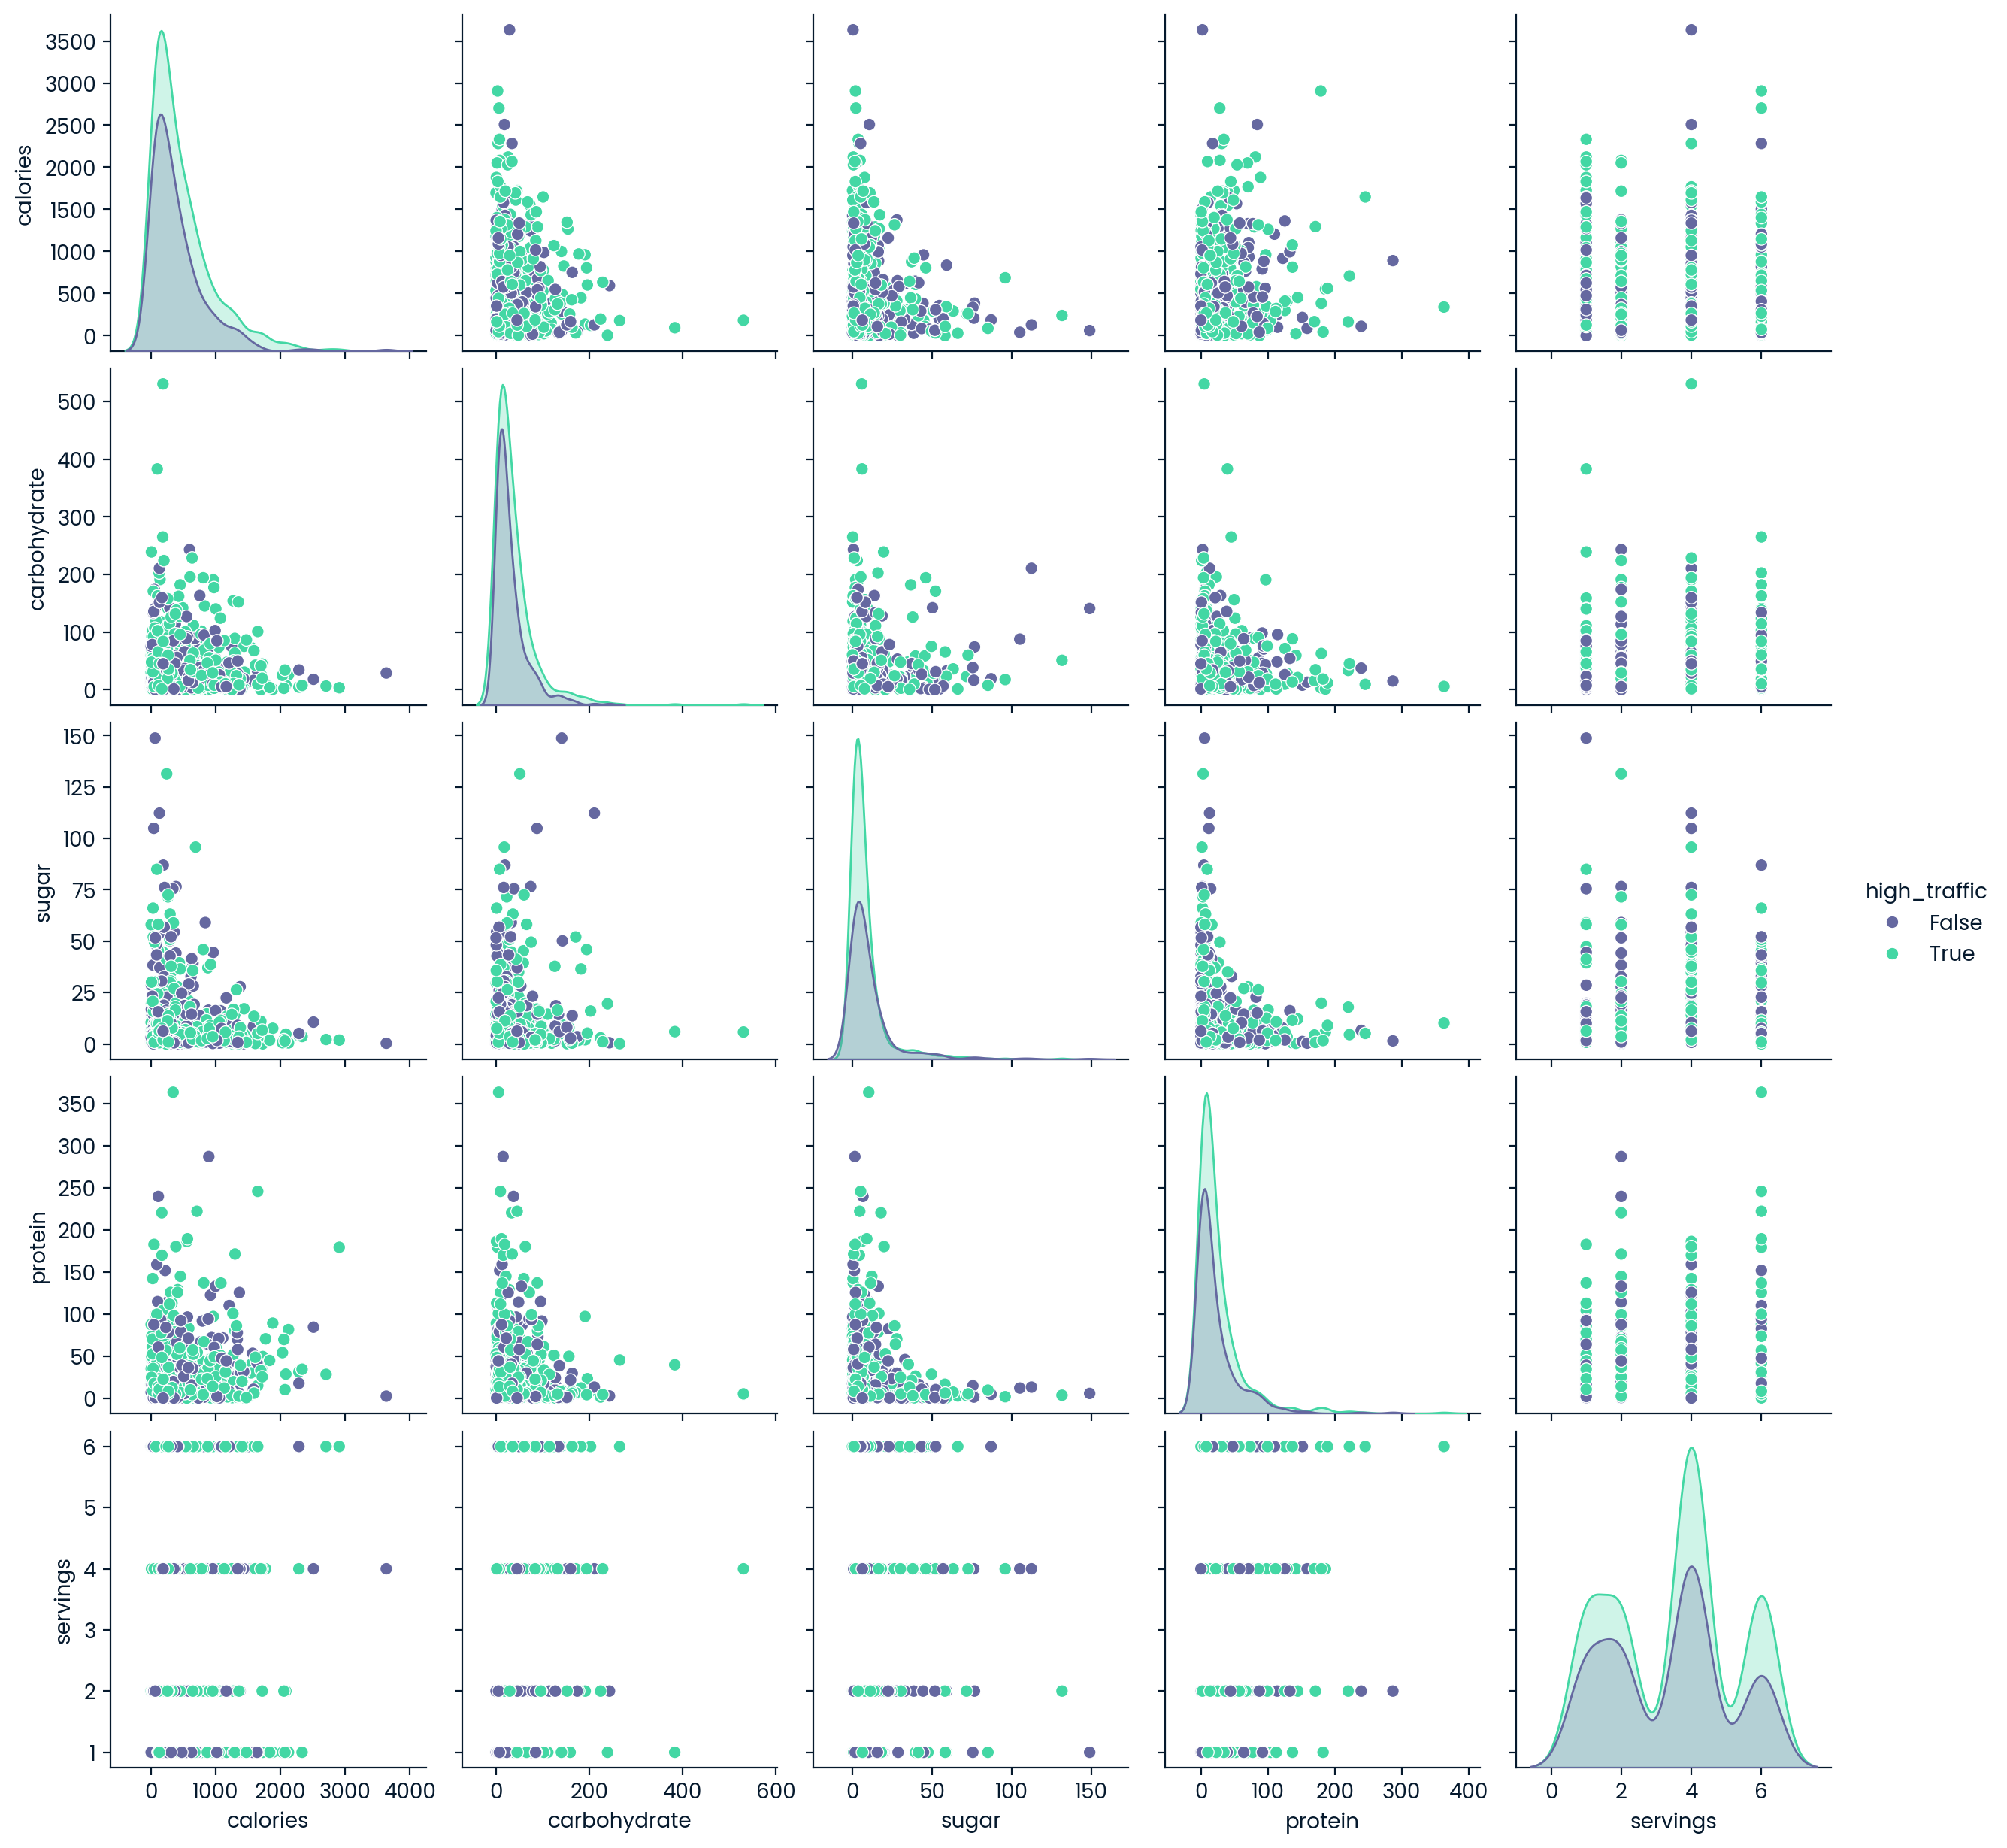

In [11]:
filtered_columns = ['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings', 'high_traffic']

sns.pairplot(df[filtered_columns], hue='high_traffic')
plt.show()

Based on the plot, there is no significant correlation between these columns. We can also see that the distribution of these nutrition values is very right-skewed.

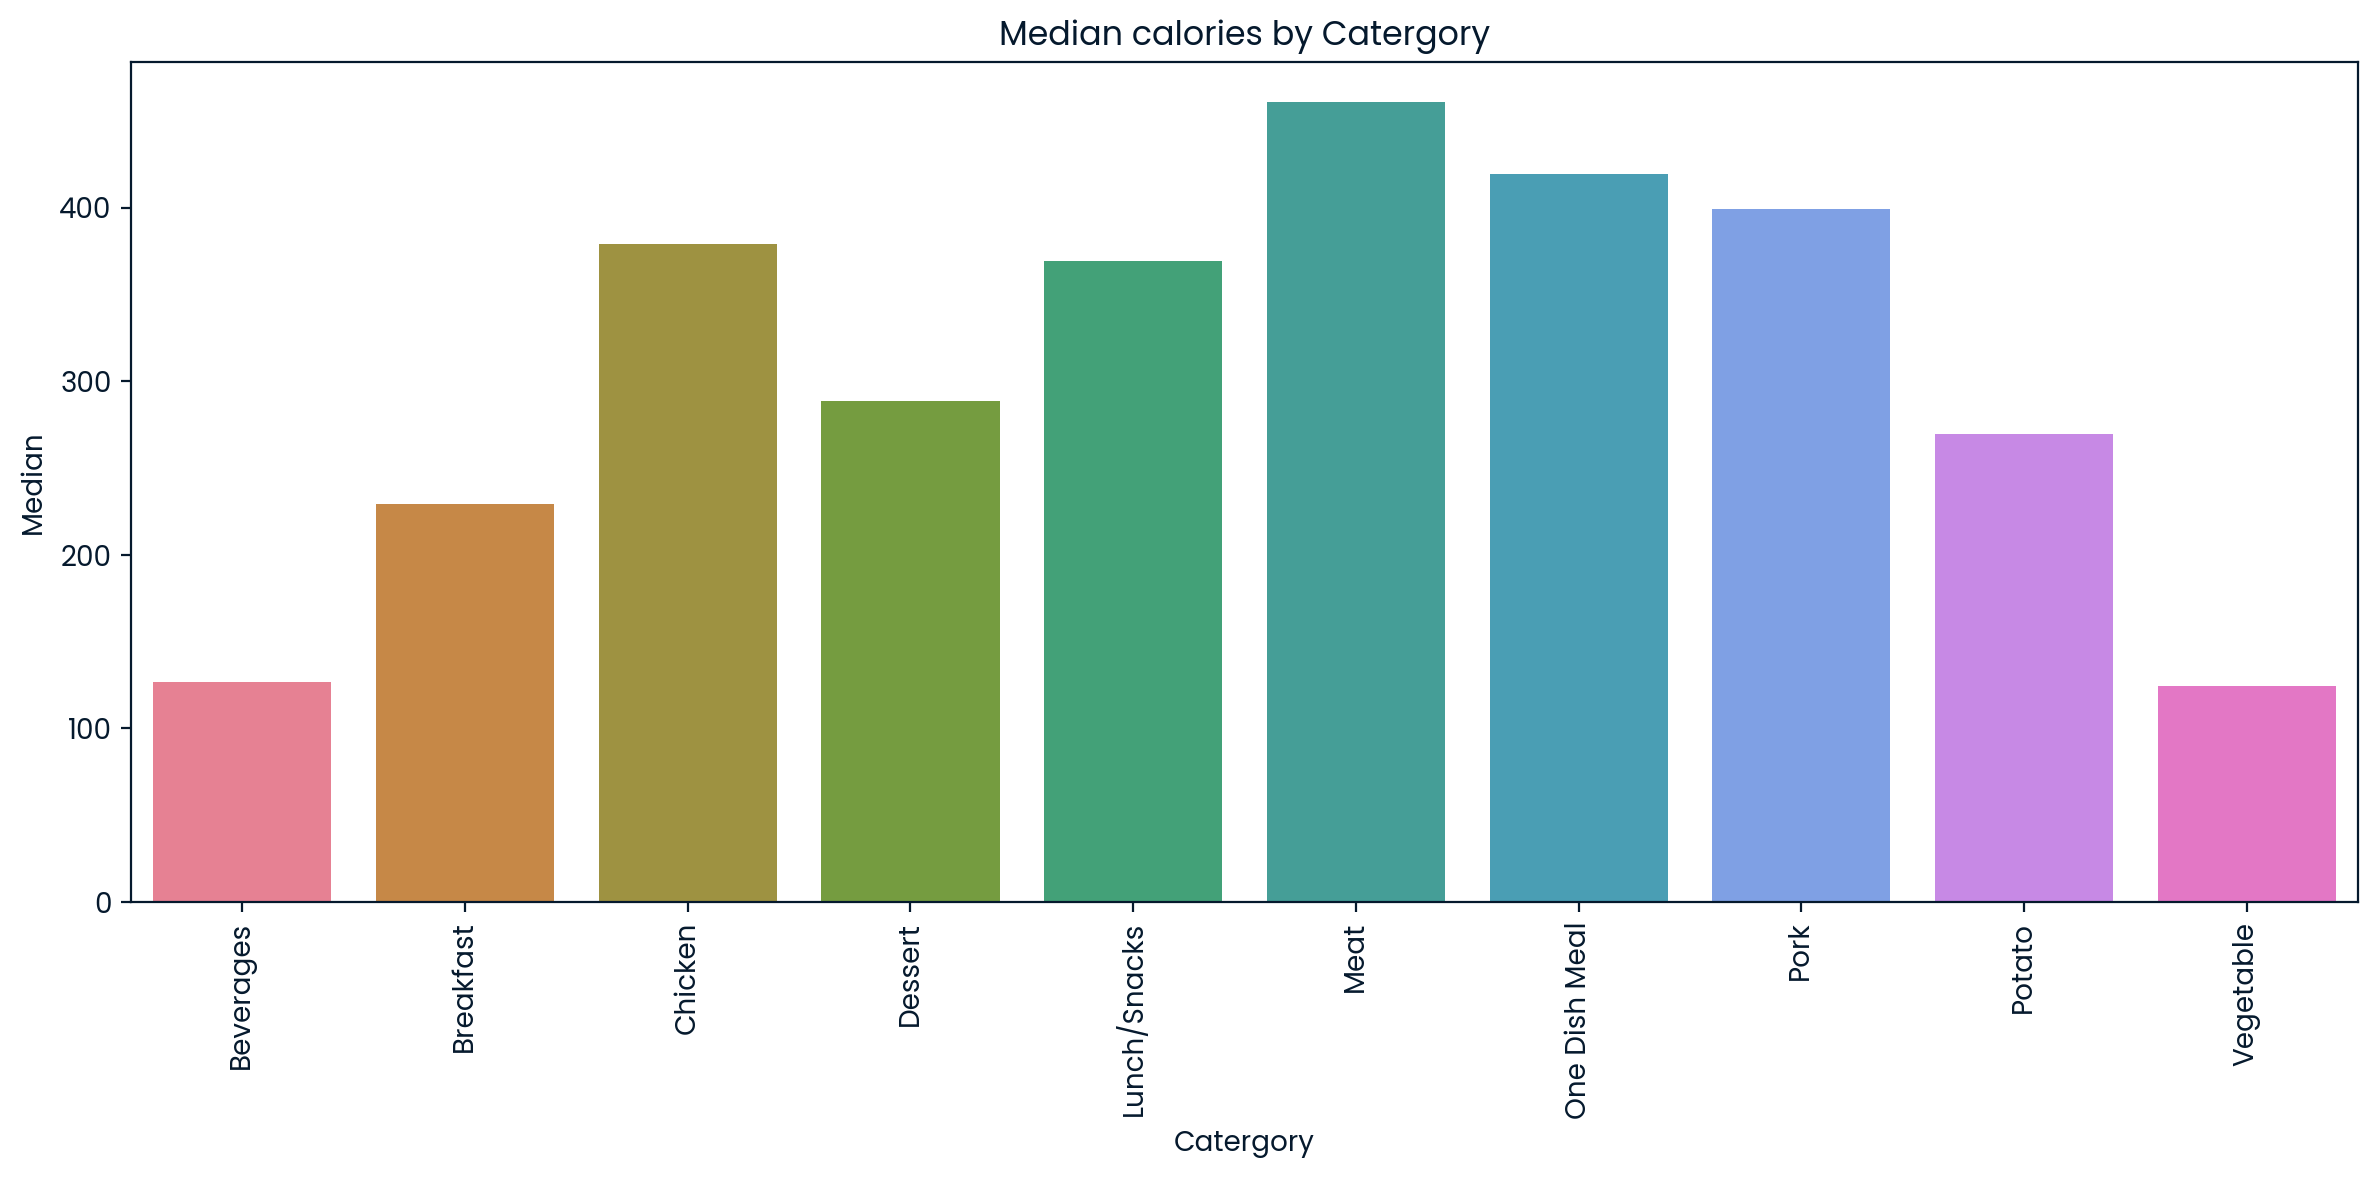

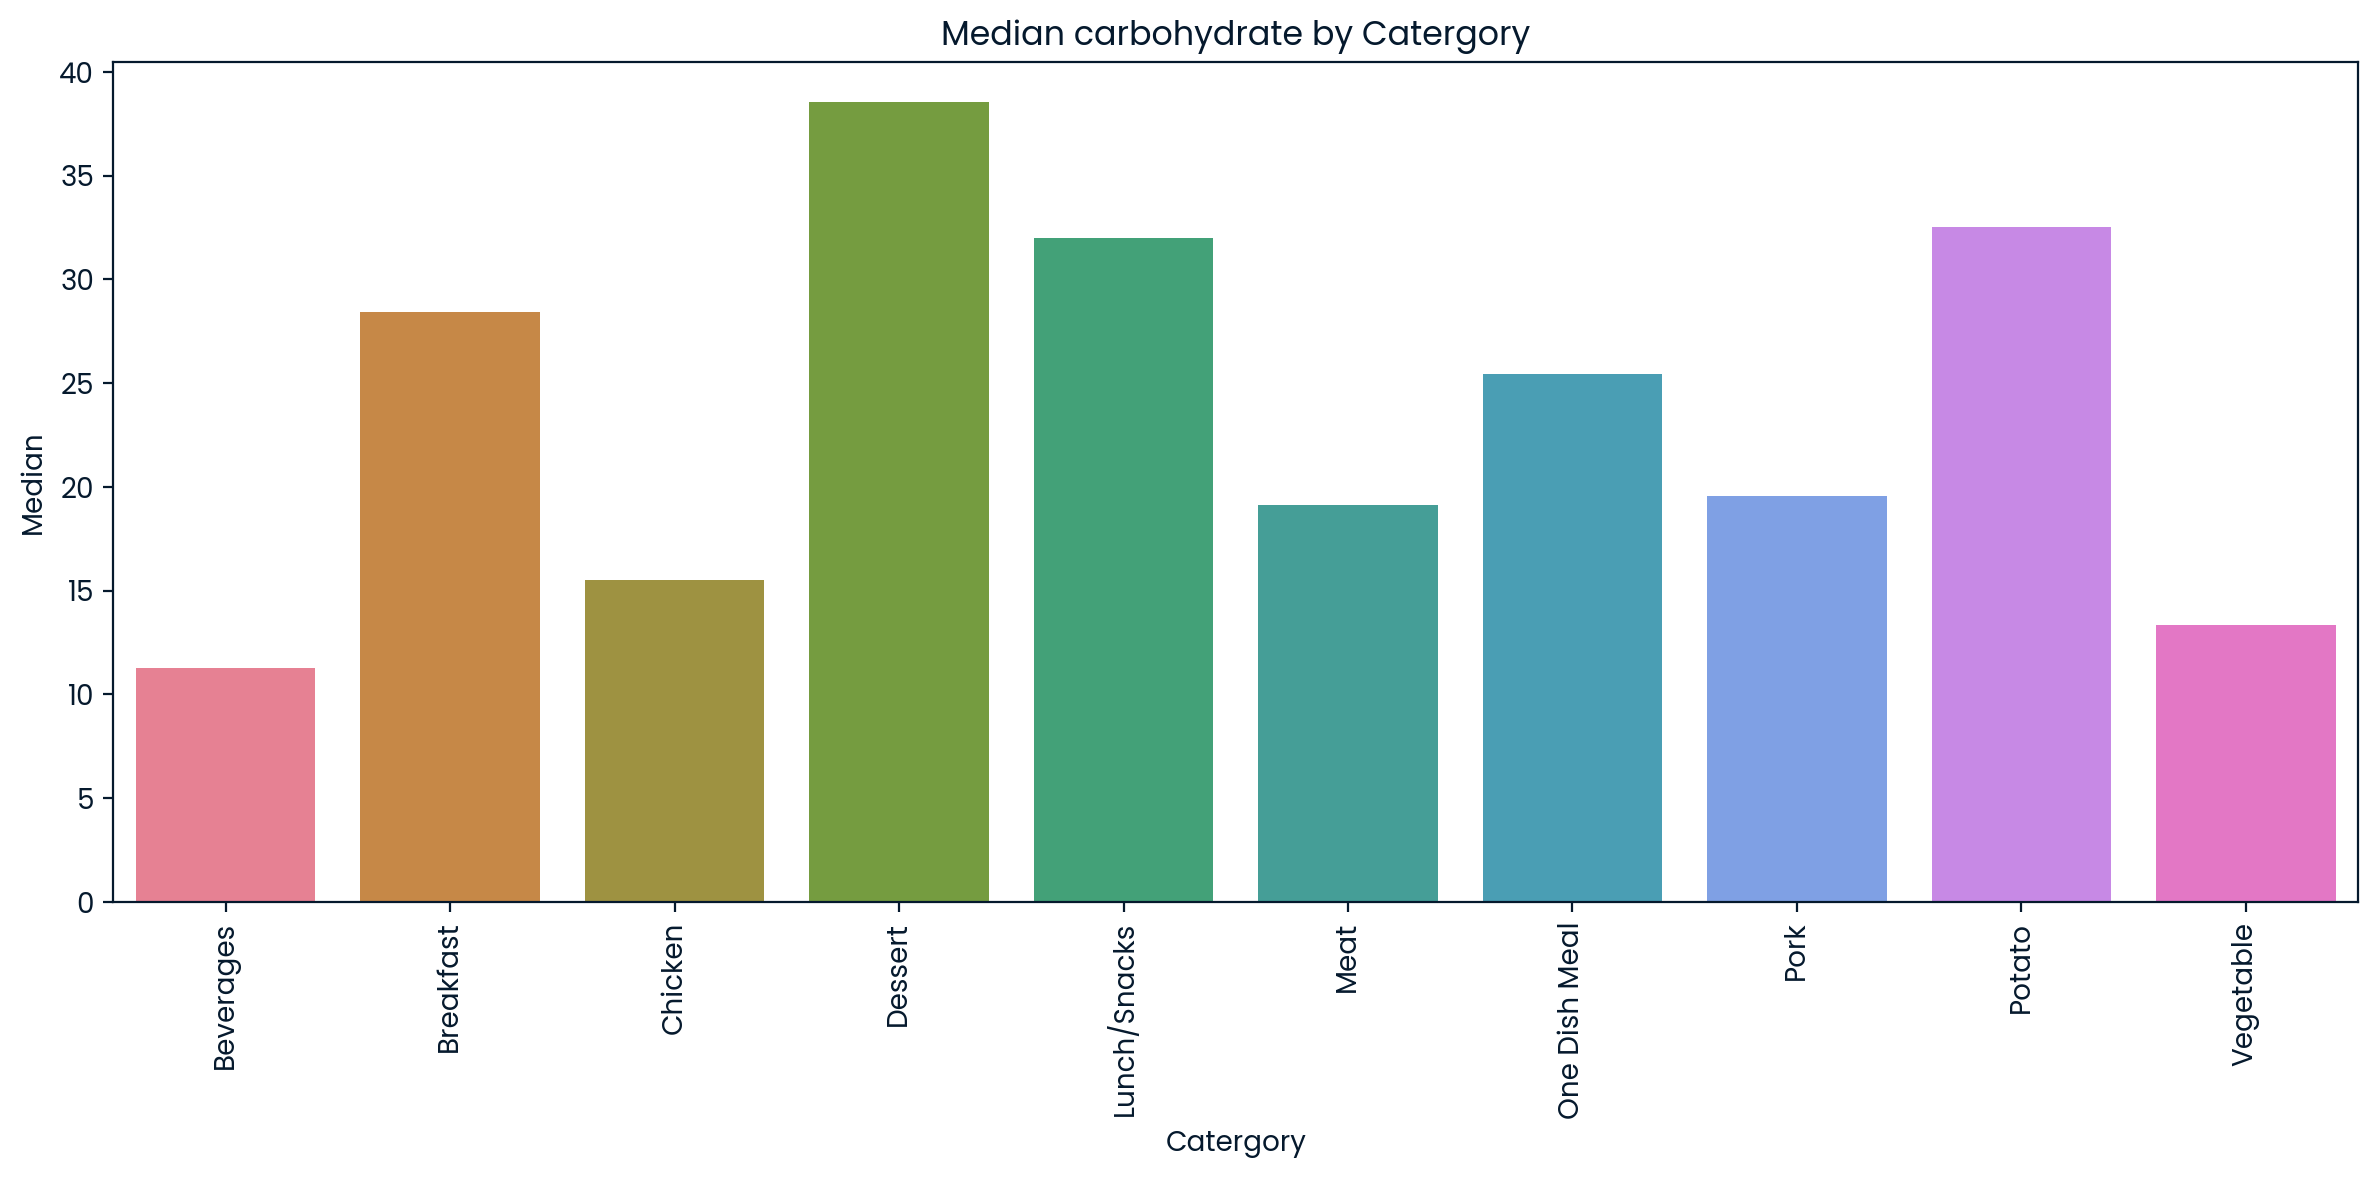

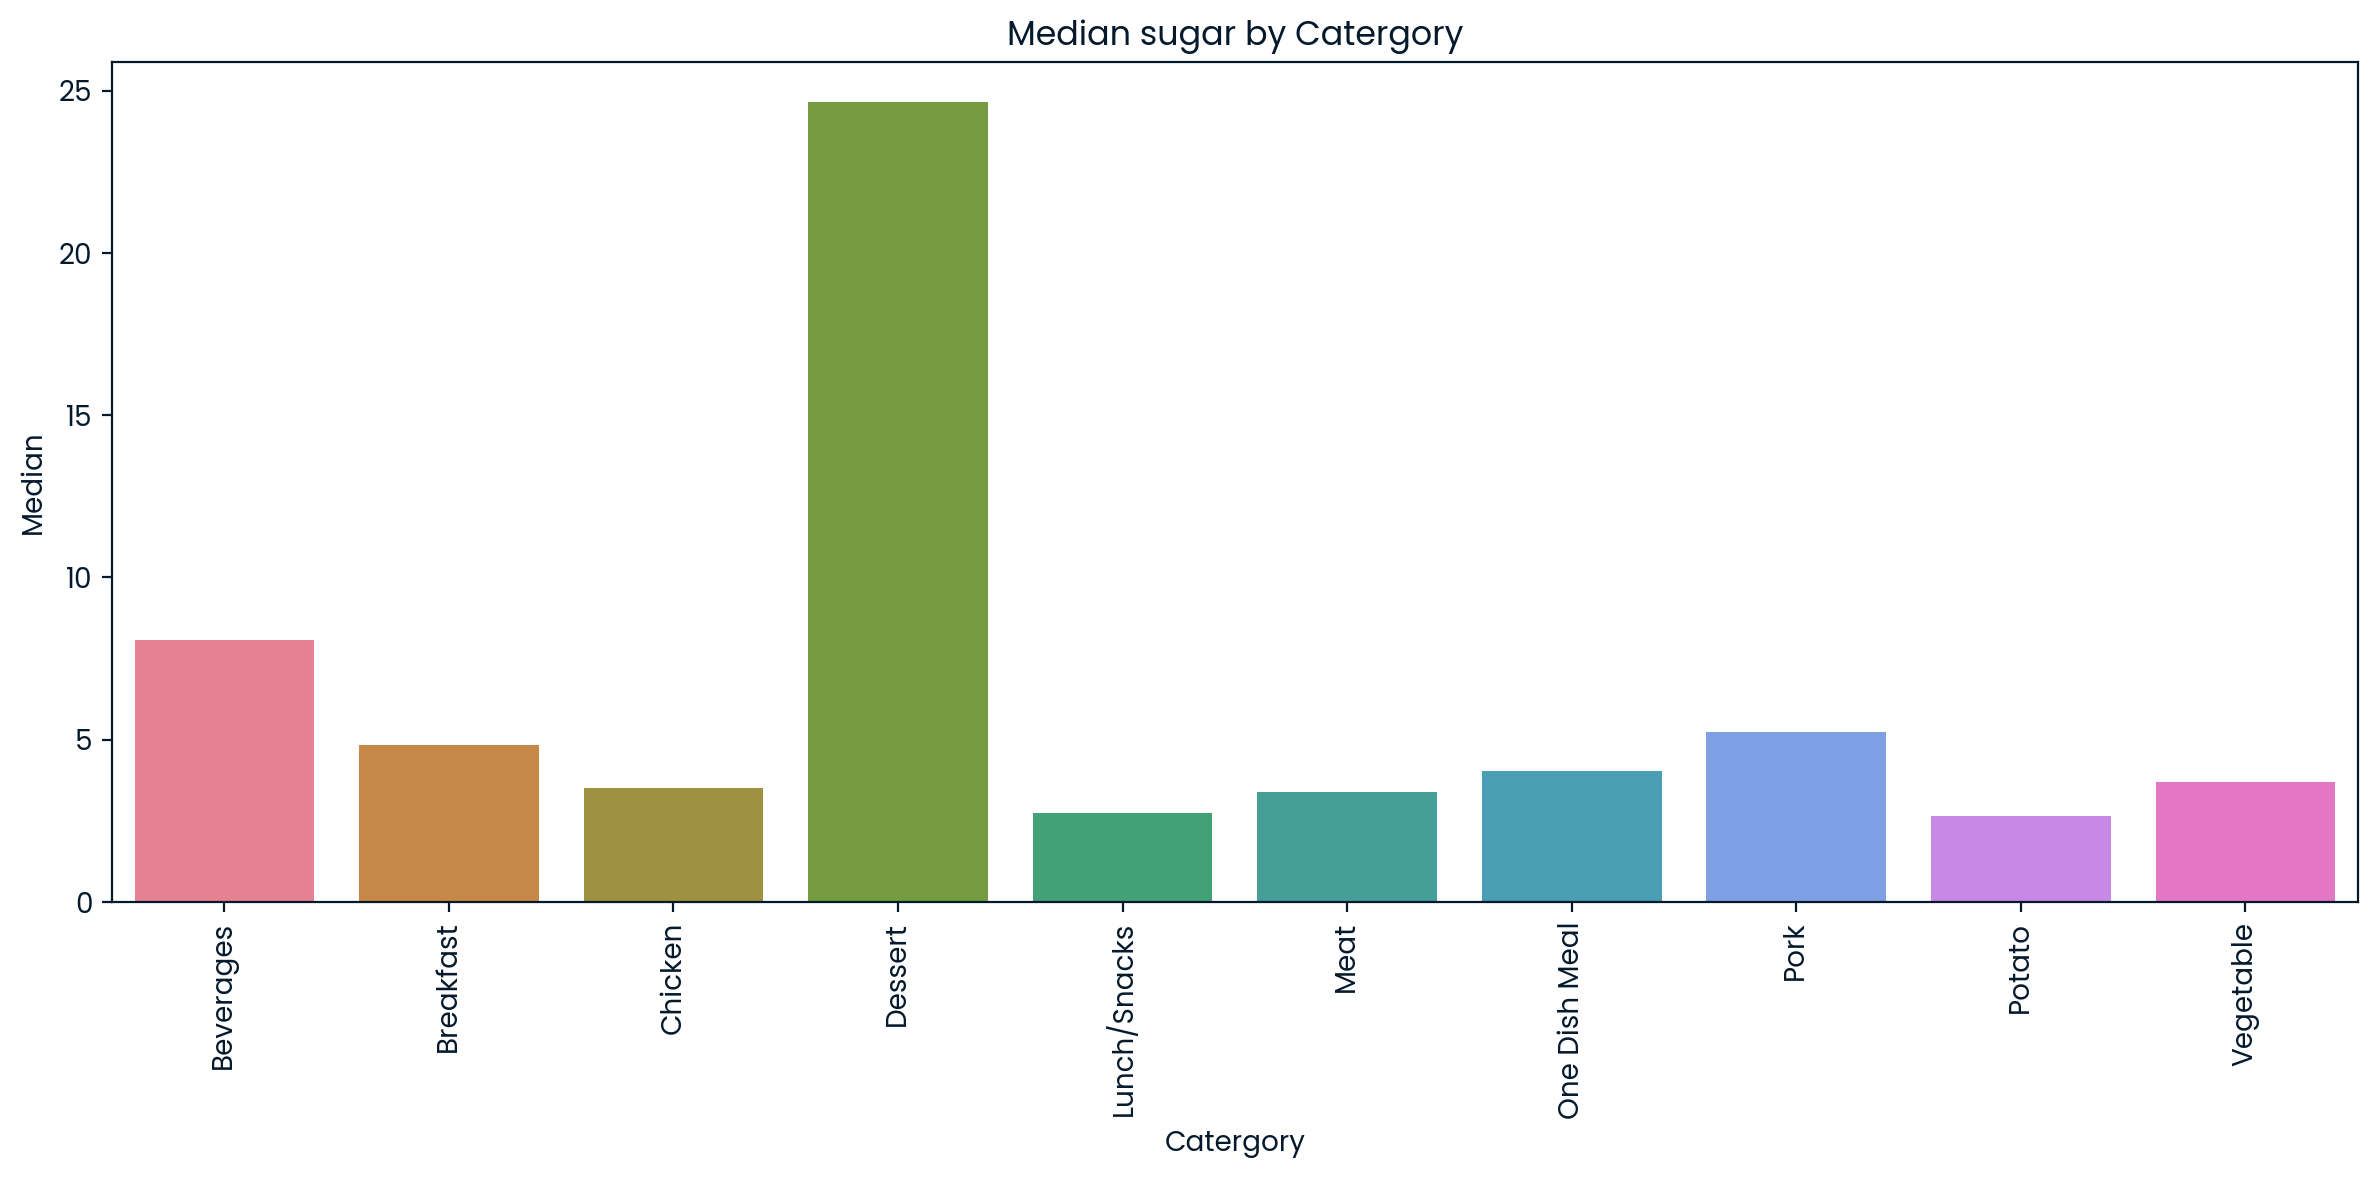

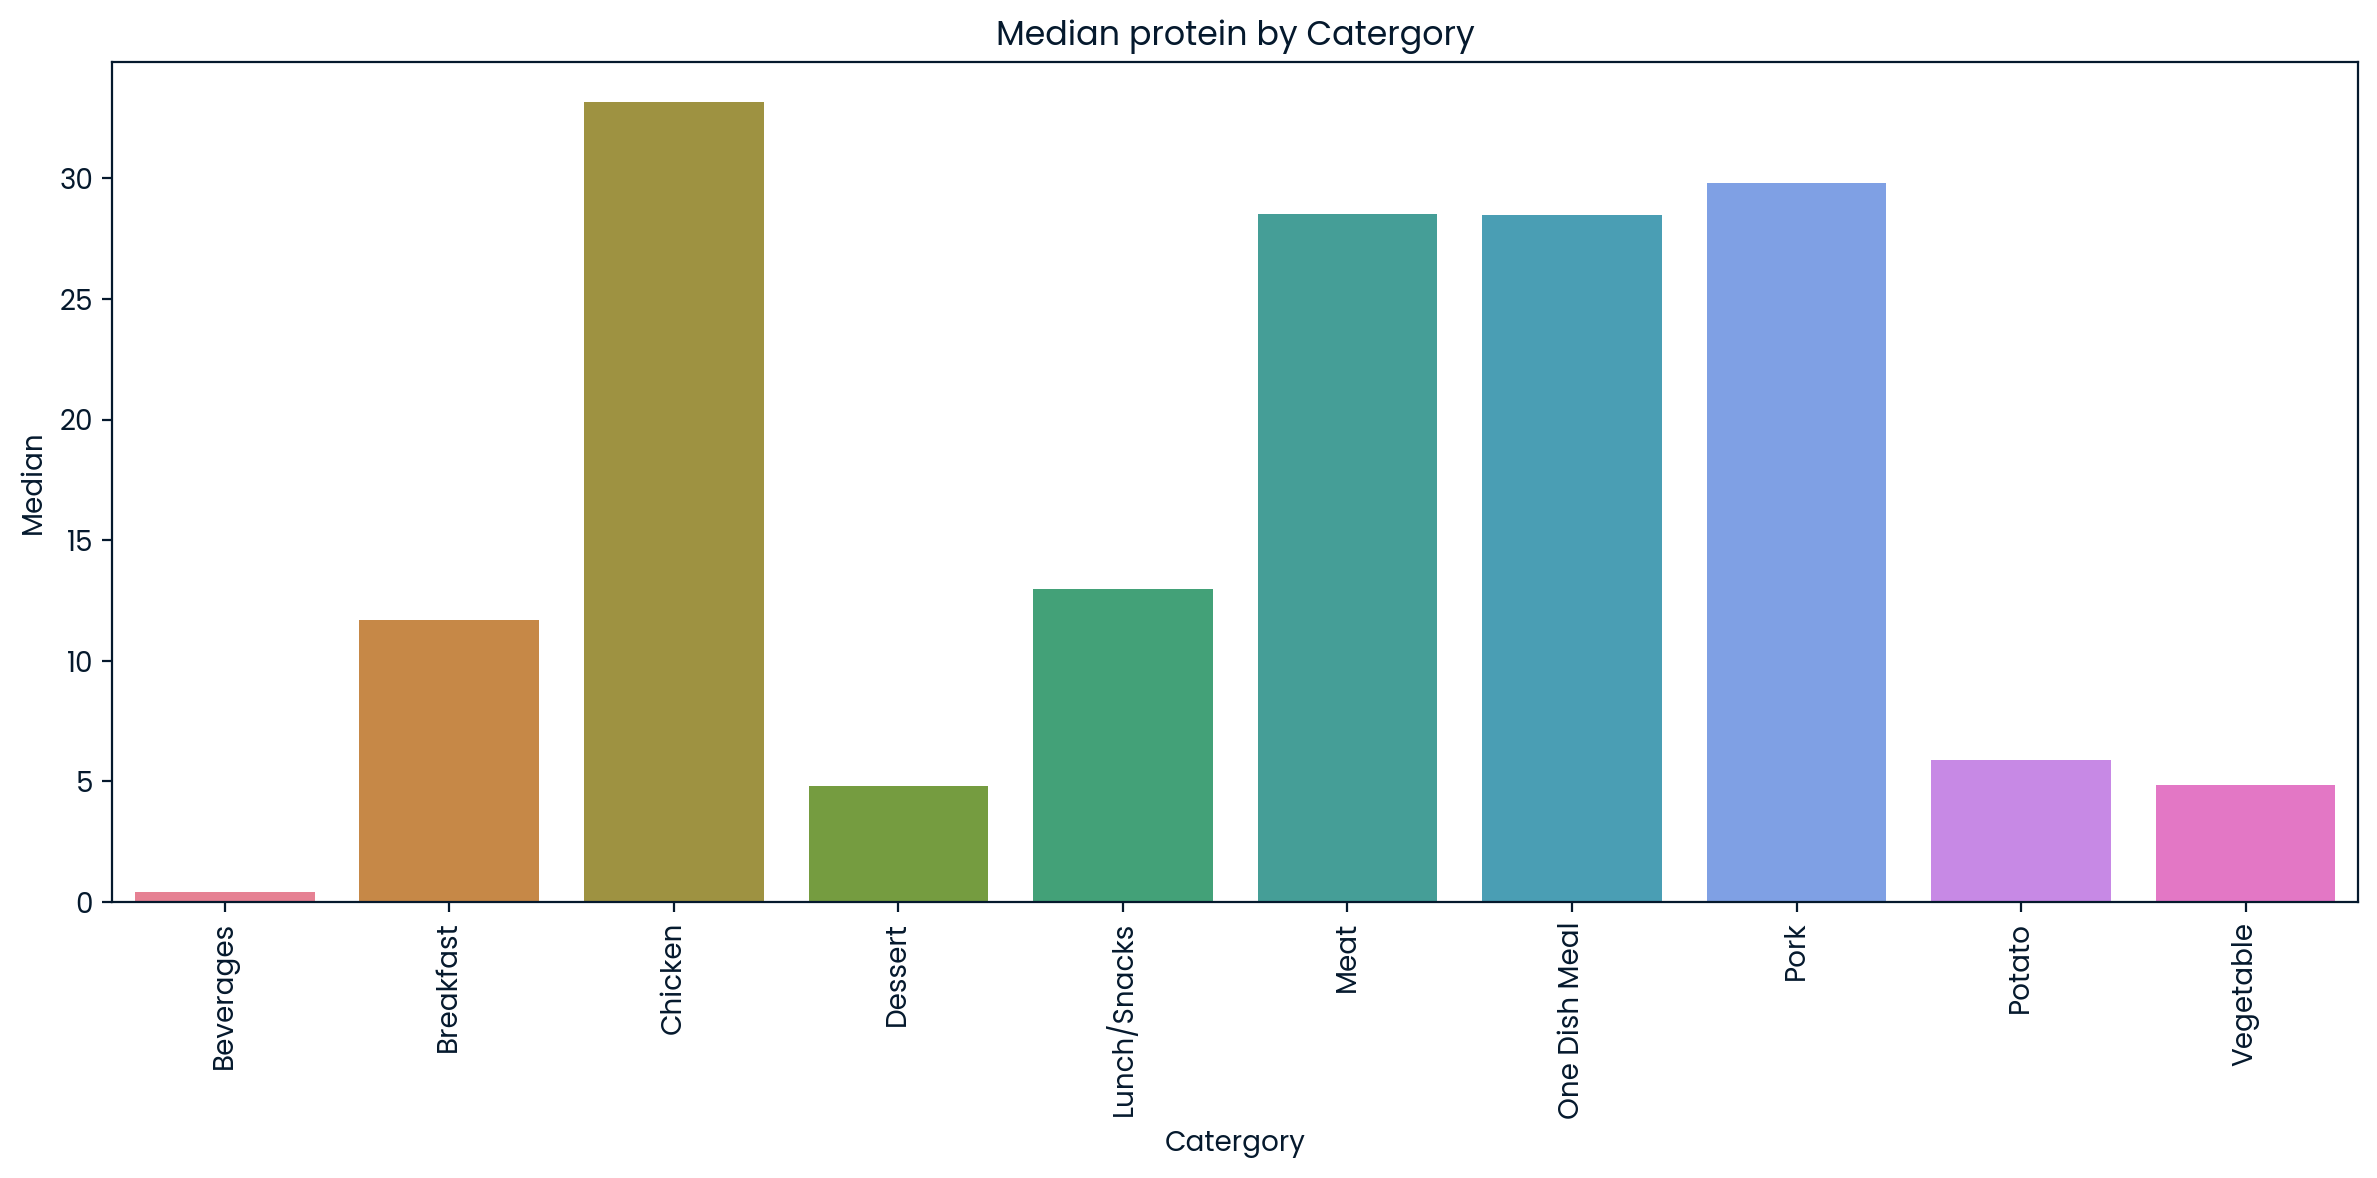

In [12]:
for column in numerical_columns:
    catergoried = df.groupby('category')[column].median()
    cat_sorted = catergoried.sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=cat_sorted.index, y=cat_sorted.values, palette="husl")
    plt.title(f"Median {column} by Catergory")
    plt.xlabel('Catergory')
    plt.ylabel('Median')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

After ploting the median nutrition values in each category, we can see that:
- Beverage has lowest protein median while chicken and pork have the highest protein median.
- Meat has the highest calories value.
- Dessert has the highest carbohydrate median followed by potato
- Dessert also has the highest sugar median followed by beverage whereas other categories contain almost no sugar.

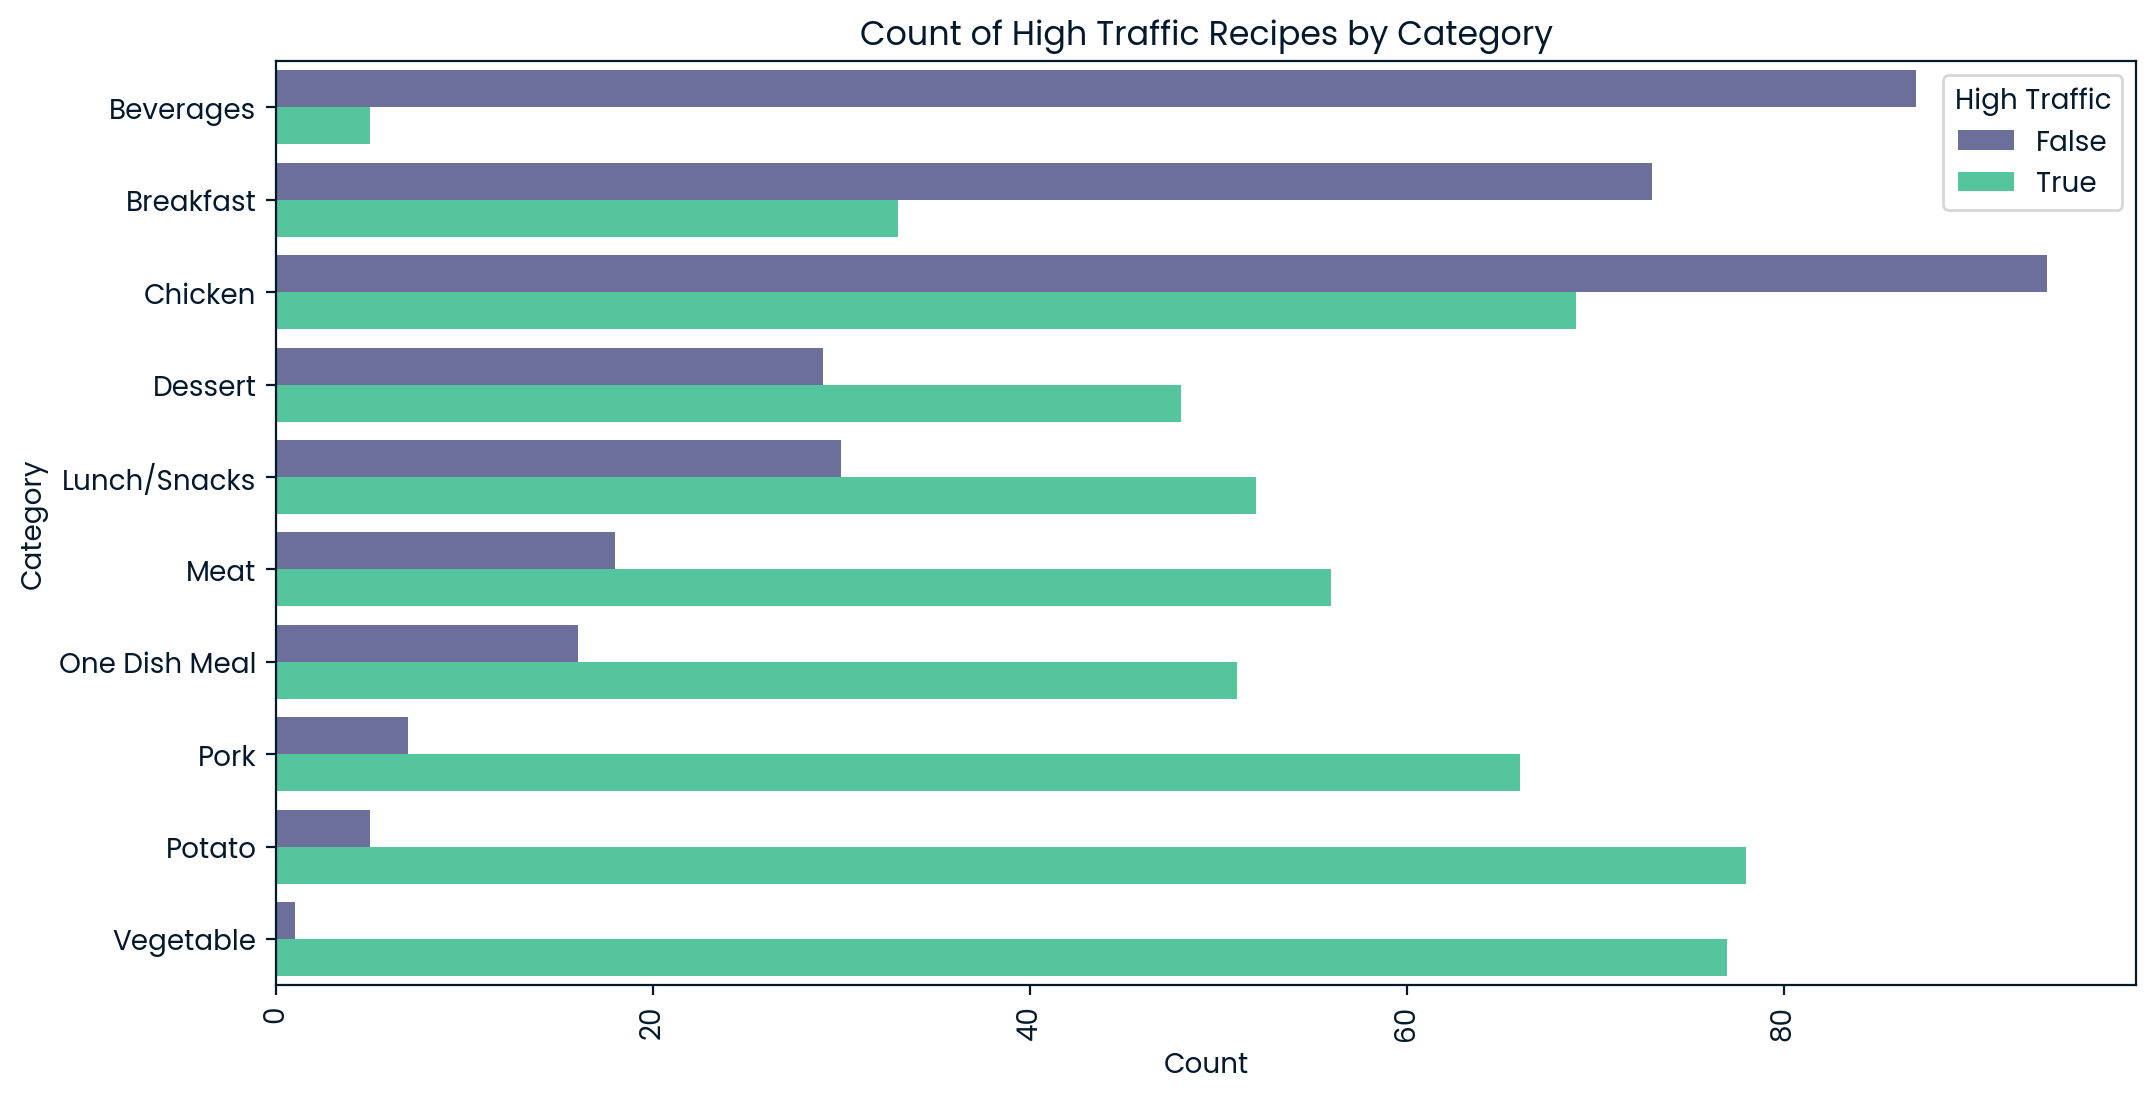

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(y="category", hue="high_traffic", data=df)

plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Count of High Traffic Recipes by Category")
plt.xticks(rotation=90)

plt.legend(title="High Traffic")
plt.show()

Based on the number of high traffic recipes by category, three highest traffic categories are: vegetable, potato and chicken.

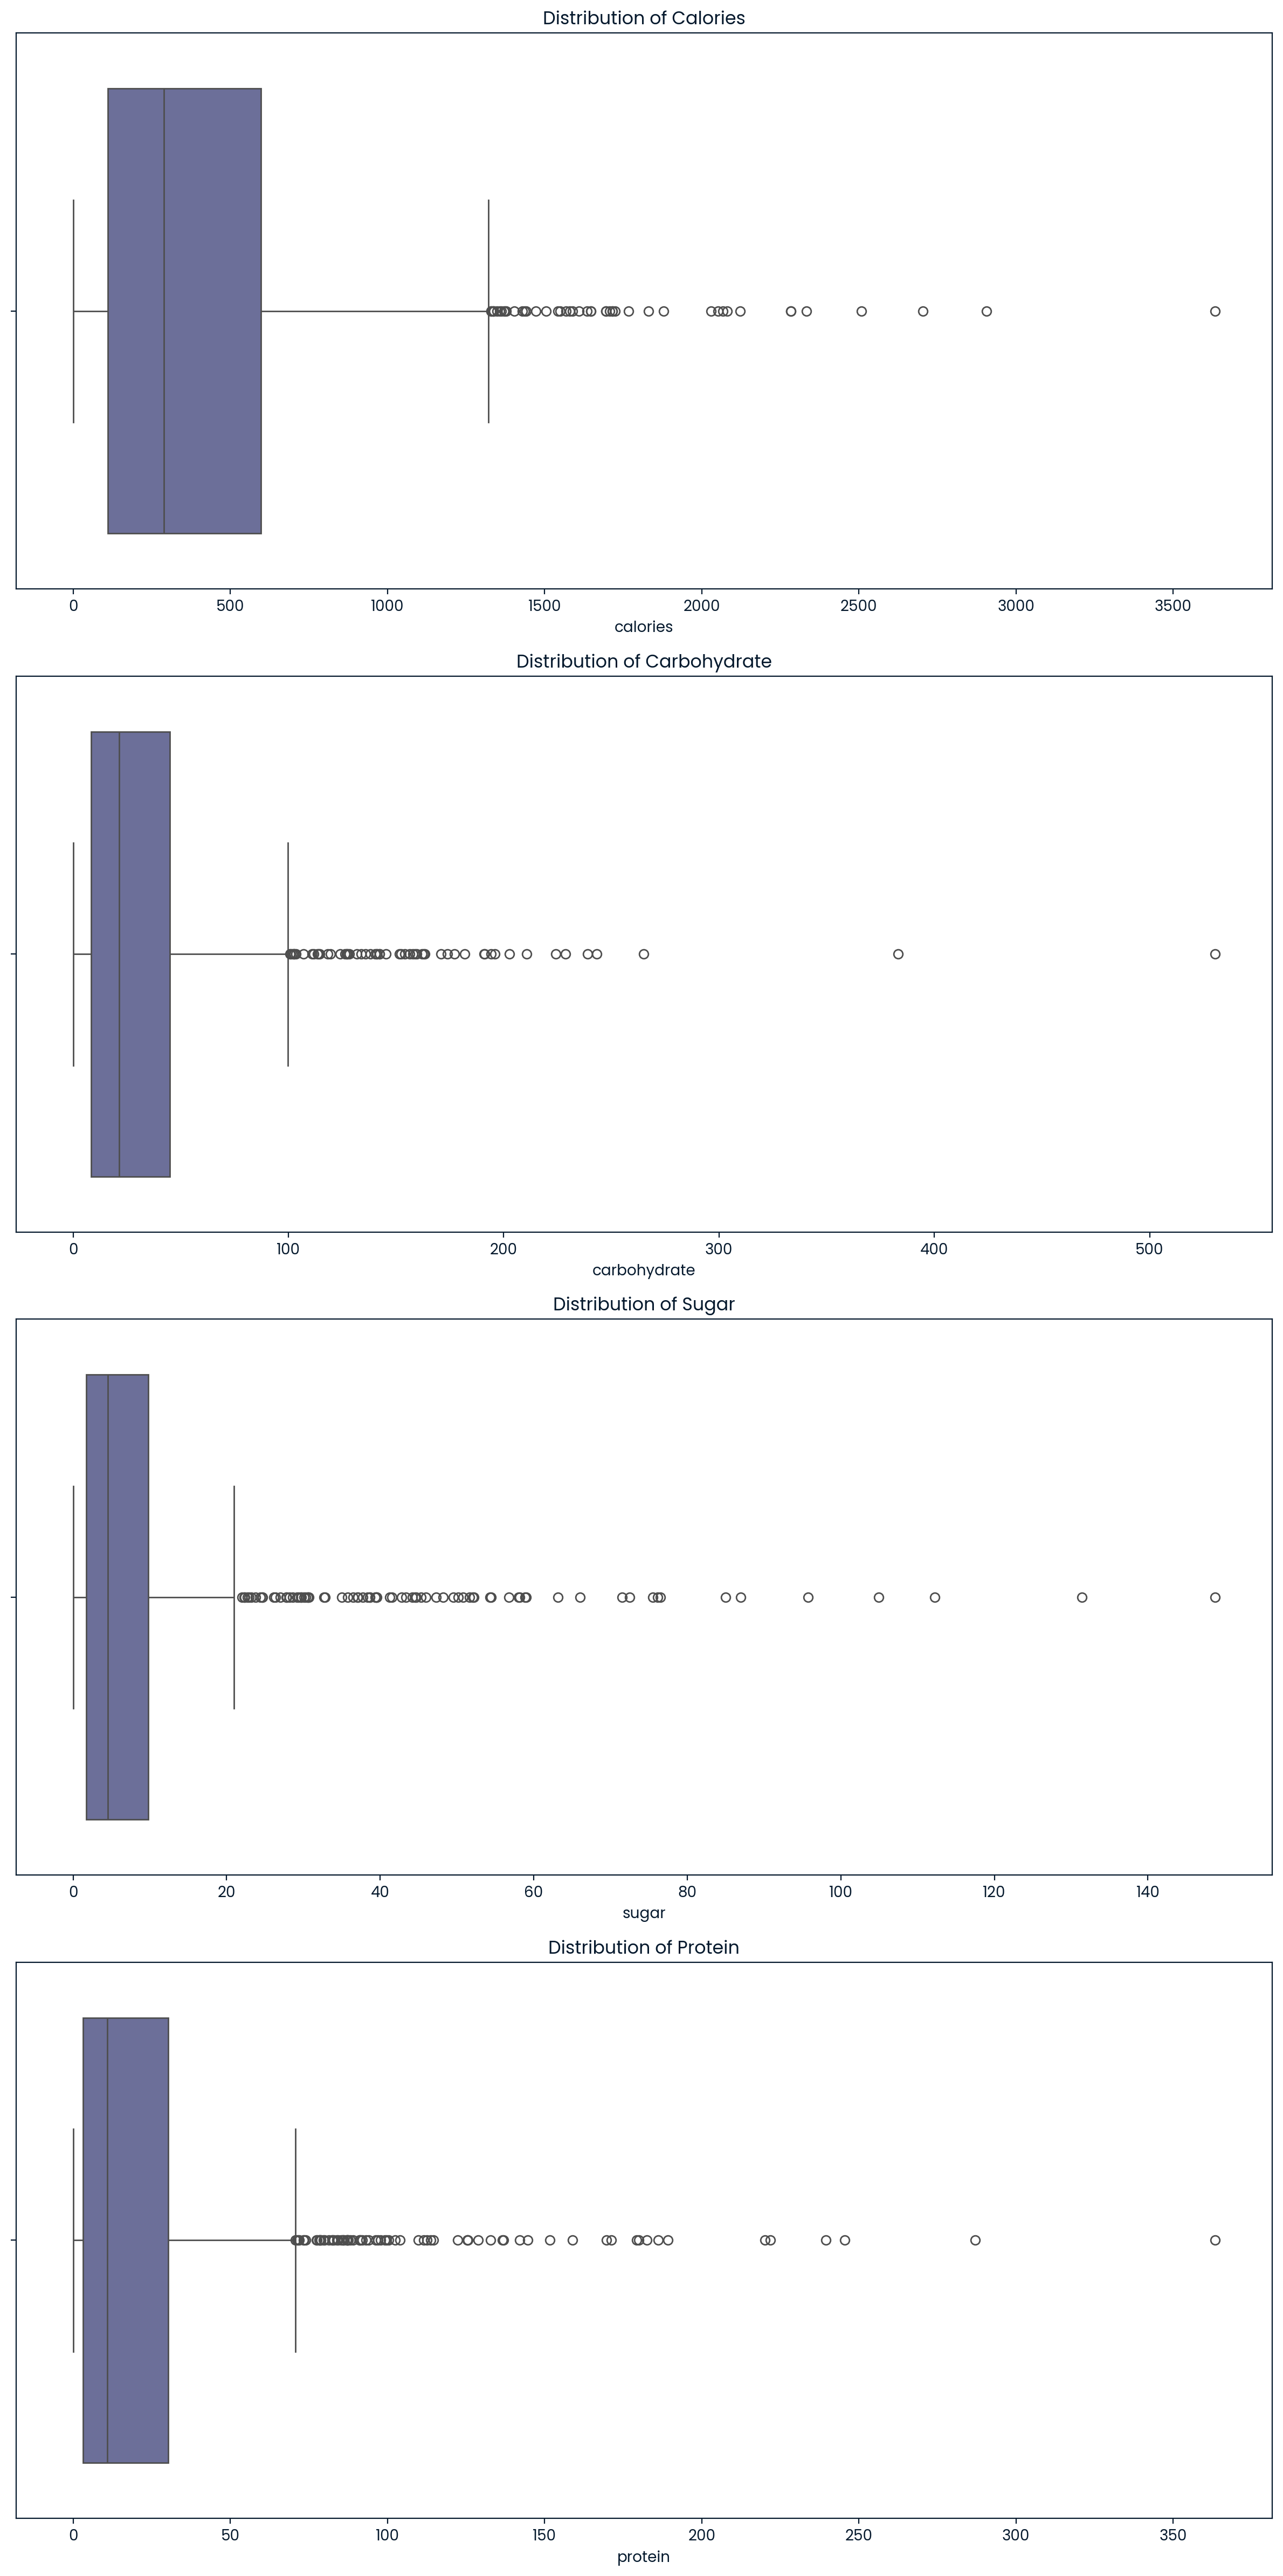

In [14]:
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(12, 6 * len(numerical_columns)))

for i, column in enumerate(numerical_columns):
    ax = axes[i]
    sns.boxplot(data=df, x=column, ax=ax)
    ax.set_title(f"Distribution of {column.capitalize()}")

plt.tight_layout()
plt.show()

The boxplots show many outliers in these nutrition values. Therefore, we will remove these outliers to provide high-quality data for training our models.

In [15]:
print(df.var())

recipe           74399.808649
calories        205228.023884
carbohydrate      1931.517412
sugar              215.478202
protein           1322.757885
servings             3.013623
high_traffic         0.240711
dtype: float64


We checked the variance in our dataset and found a significant disparity among the nutrition values. Therefore, we applied log normalization to bring the columns to a relatively similar scale. Since one recipe had a protein value of 0, and the logarithm of zero or a negative number is undefined, we replaced it with a very small positive number.

In [16]:
df['protein'] = df['protein'].replace(0, 1e-6)
df["calories"] = np.log(df.calories)
df["carbohydrate"] = np.log(df.carbohydrate)
df["protein"] = np.log(df.protein)
df["sugar"] = np.log(df.sugar)

In [17]:
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)

IQR = Q3 - Q1

# An outlier is defined as a value that is below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outlier_mask = ~((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

df = df[outlier_mask]

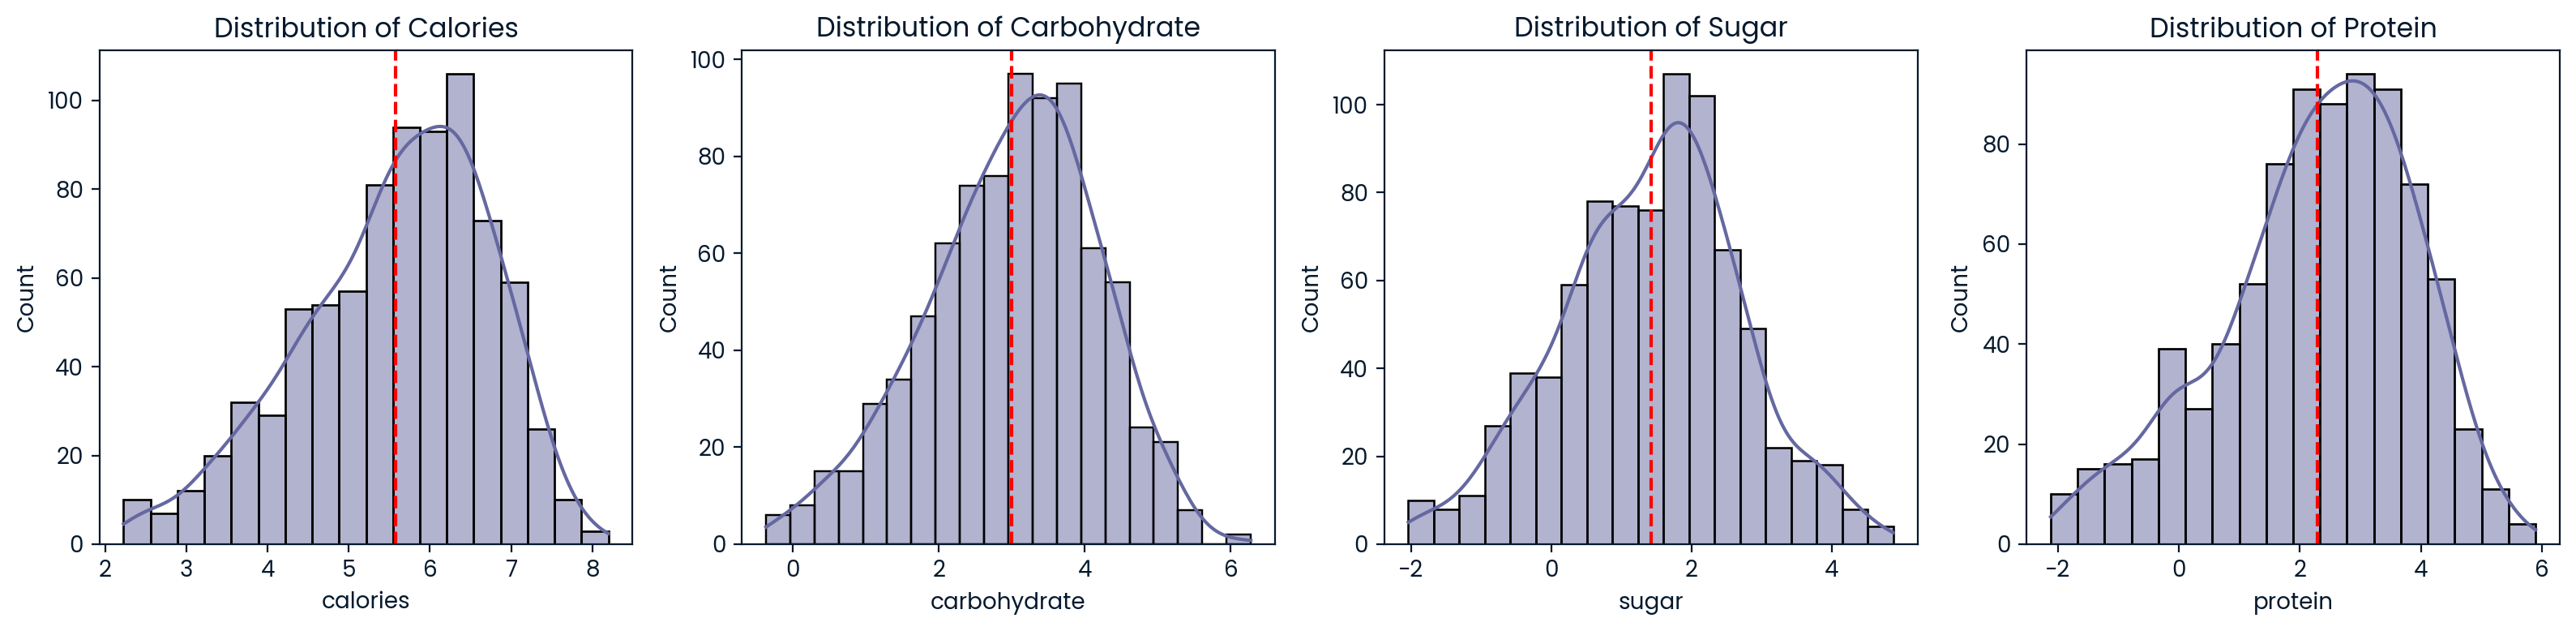

In [18]:
plt.figure(figsize=(16, 4))
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=df, x=column, kde=True)
    plt.axvline(np.mean(df[column]), color='red', linestyle='--', label='Mean')
    plt.title(f"Distribution of {column.capitalize()}")

plt.tight_layout()
plt.show()

In [19]:
le = LabelEncoder()
df["category_enc"] = le.fit_transform(df["category"])

In [20]:
df =  df.drop("category", axis=1)
print(df.var())

recipe          73654.140335
calories            1.339424
carbohydrate        1.373915
sugar               1.653861
protein             2.527289
servings            2.959349
high_traffic        0.238080
category_enc        8.049652
dtype: float64


[Text(0.5, 0, 'recipe'),
 Text(1.5, 0, 'calories'),
 Text(2.5, 0, 'carbohydrate'),
 Text(3.5, 0, 'sugar'),
 Text(4.5, 0, 'protein'),
 Text(5.5, 0, 'servings'),
 Text(6.5, 0, 'high_traffic'),
 Text(7.5, 0, 'category_enc')]

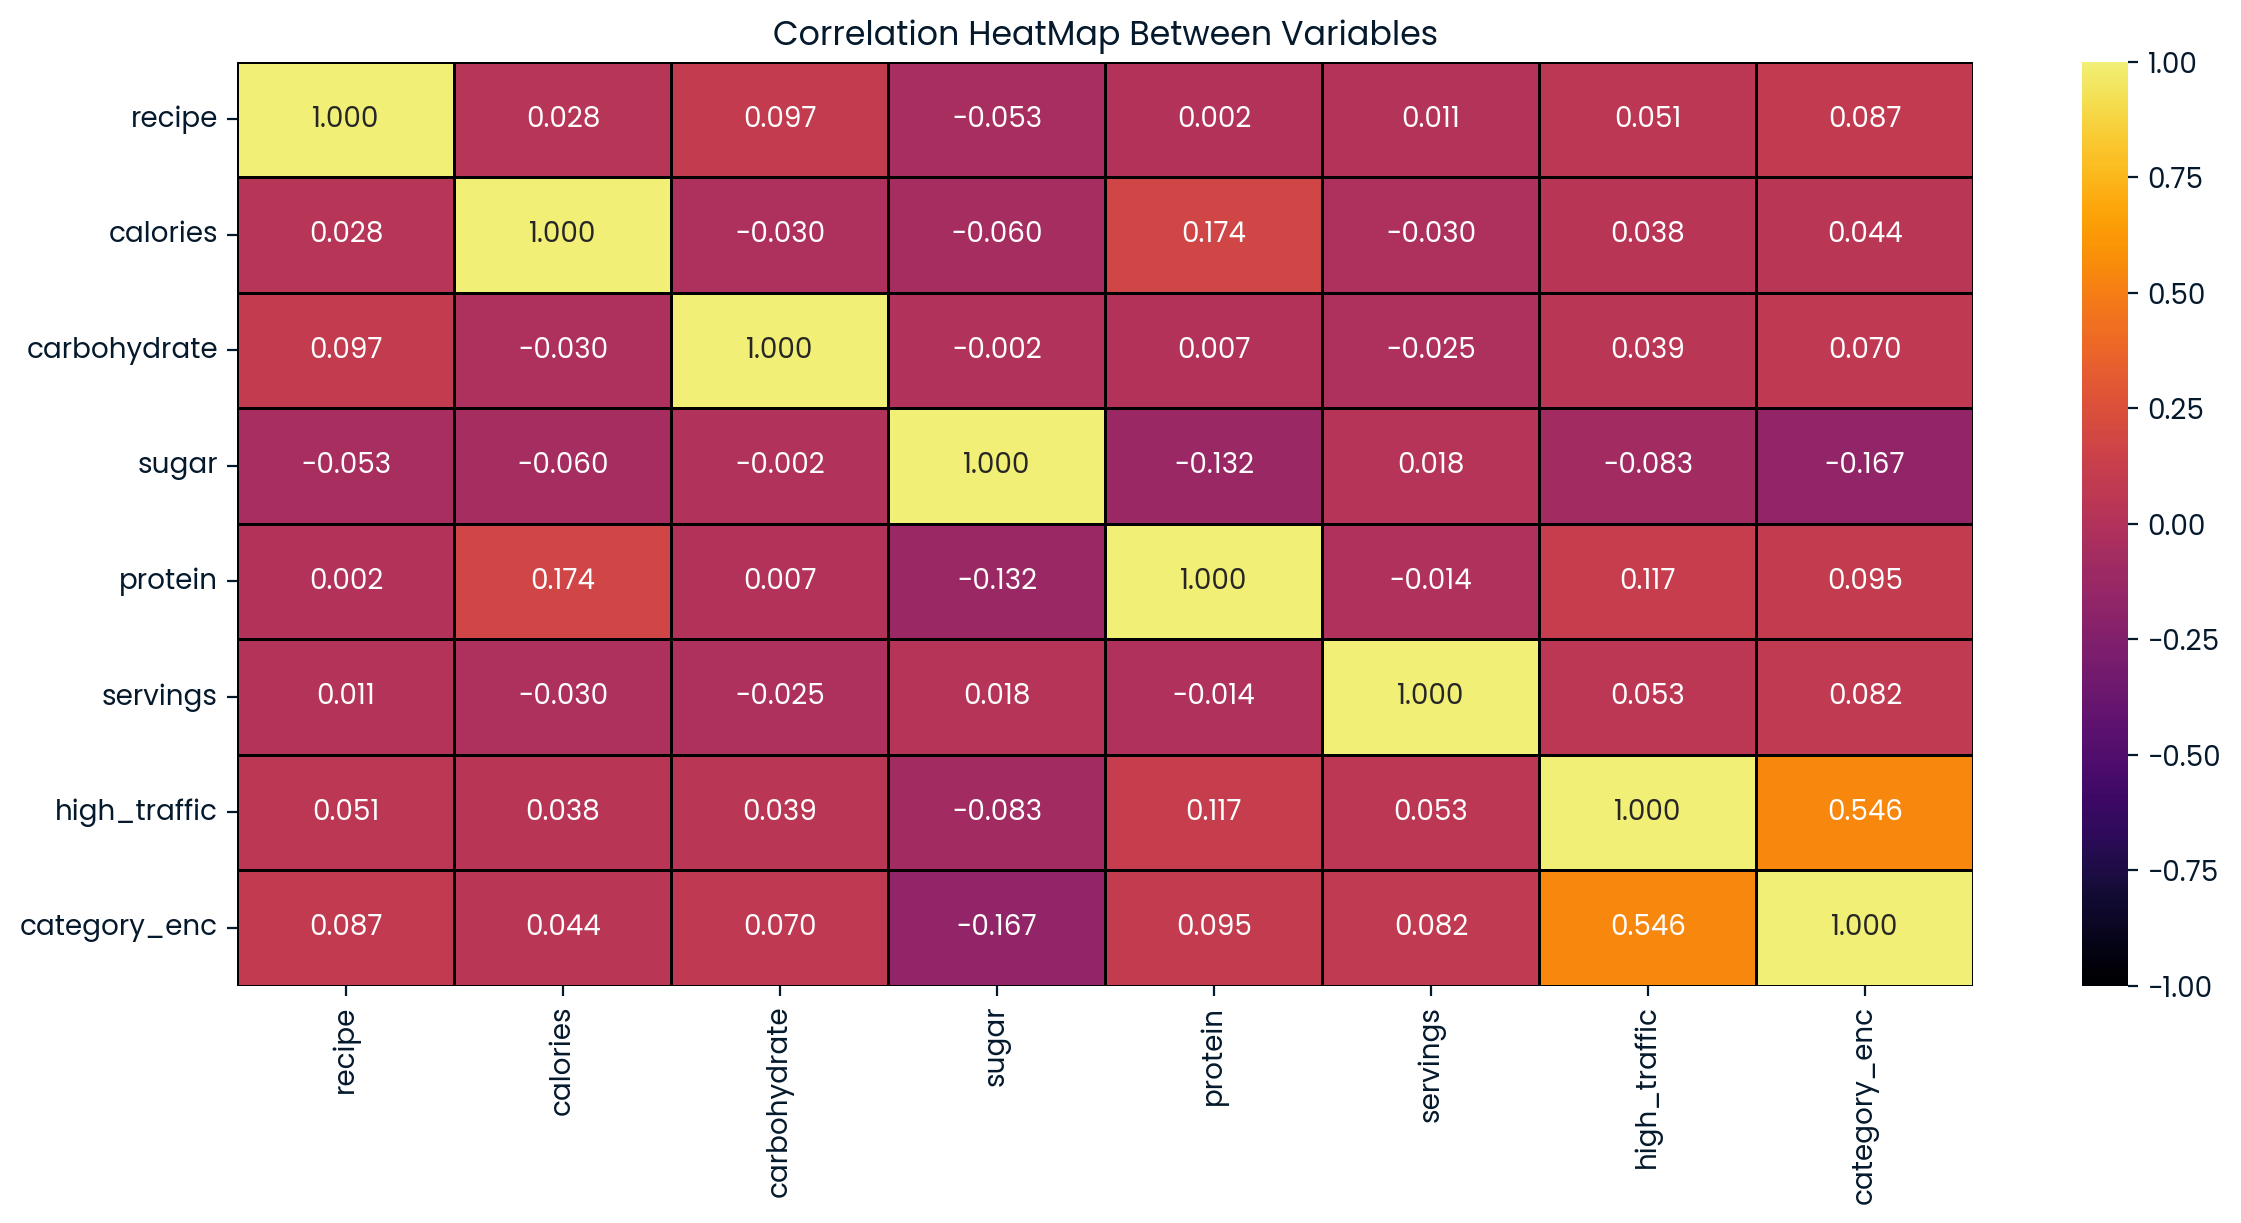

In [21]:
corr_df = df.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(14,6))
heatmap = sns.heatmap(corr_df,annot=True,fmt='.3f', vmin=-1.0, vmax=1.0, center=0.05, cmap='inferno', linewidths=1, linecolor='Black')
heatmap.set_title("Correlation HeatMap Between Variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90)

The correlation heatmap confirms that there is no high correlation between the columns. The column most correlated with high_traffic is category, with a correlation coefficient of 0.546. This suggests a moderate positive relationship, indicating that as the certain category value increases, the likelihood of high traffic also increases.

## Model Development

In [22]:
def generate_data(n, p,
                  beta_range = [0, 2],
                  sigma = 1.0,
                  corr: np.array = None) -> tuple:
  p = int(p)
  if corr is None:
    covar = np.diag(np.full(p, sigma))
  else:
    assert(corr.shape[0] == p)
    assert(corr.shape[1] == p)
    covar = corr * sigma
  X = np.random.multivariate_normal(np.zeros(p), covar, n)

  assert(len(beta_range) == 2)
  assert(beta_range[0] <= beta_range[1])
  beta = np.random.uniform(size = p, low = beta_range[0], high = beta_range[1])
  eta = np.dot(X, beta)
  mu = np.exp(eta) / (1 + np.exp(eta))

  y = np.random.binomial(n = 1, p = mu)

  return X, y, beta

In [23]:
n = 895
p = 10
np.random.seed(8657309)
X, y, beta = generate_data(n = n, p = p)

In [24]:
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size = 0.2, random_state = 8675309)
)

In order to validate the model, we first split the data into a training set and a test set using a random seed. This ensures that there is no data leakage and helps reduce bias between the training and test sets. By maintaining a consistent random seed, we can reproduce the results across different runs, allowing for a fair evaluation of the model's performance on unseen data. This process is crucial for assessing the model's generalization ability and ensuring that the results are reliable and not influenced by random variations in the data.

## Logistic Regression

To predict a recipe is high traffic or not, we use logistic regression. It is less likely to overfit and it outputs probabilities of each class (high traffic, low traffic), allowing for a nuanced understanding of predictions.

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

In [27]:
np.array([lr.coef_[0], beta]).T

array([[0.85228176, 0.74946432],
       [0.79295516, 0.77496127],
       [0.66540768, 0.83438651],
       [0.3168768 , 0.17226868],
       [2.16971524, 1.95631894],
       [0.08838005, 0.27194563],
       [0.09236009, 0.03000149],
       [0.32516617, 0.4062392 ],
       [1.40764279, 1.29180891],
       [0.46660483, 0.49827277]])

In [28]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lr_auroc = auc(lr_fpr, lr_tpr)

In [29]:
lr_p, lr_r, _ = precision_recall_curve(y_test, lr_pred)
lr_auprc = auc(lr_r, lr_p)

## Random Forest

Random Forest is an ensemble learning method that combines multiple decision trees to improve predictive accuracy and control overfitting. Since it is robust to outliers and can handle missing values, we want to train this model using our train dataset.

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)[:, 1]

In [31]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred)
rf_auroc = auc(rf_fpr, rf_tpr)

In [32]:
rf_p, rf_r, _ = precision_recall_curve(y_test, rf_pred)
rf_auprc = auc(rf_r, rf_p)

In [33]:
def plot_models(x1: np.array,
                y1: np.array,
                auc1: float,
                x2: np.array,
                y2: np.array,
                auc2: float,
                label: str,
                color_values: list = ['steelblue', 'darkgoldenrod'],
                font_size: int = 14,
                figure_size: list = [10, 6],
                legend_position: list = [0.3, 0.15]):
  
    label1 = f'Logistic Regression ({label} = {auc1:.3f})'
    label2 = f'Random Forest ({label} = {auc2:.3f})'
  
    plt.figure(figsize=figure_size)
    plt.plot(x1, y1, label=label1, color=color_values[0], lw=2)
    plt.plot(x2, y2, label=label2, color=color_values[1], lw=2)
  
    if label == 'AUROC':
        xlab = 'False Positive Rate'
        ylab = 'True Positive Rate'
        # Plot the diagonal line for AUROC
        plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--', alpha=0.5)
    else:
        xlab = 'Recall'
        ylab = 'Precision'
    
    plt.xlabel(xlab, fontsize=font_size)
    plt.ylabel(ylab, fontsize=font_size)
    plt.title(f'{label} Comparison', fontsize=font_size + 2)
  
    plt.legend(loc='best', fontsize=font_size)
  
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

## Model Validation

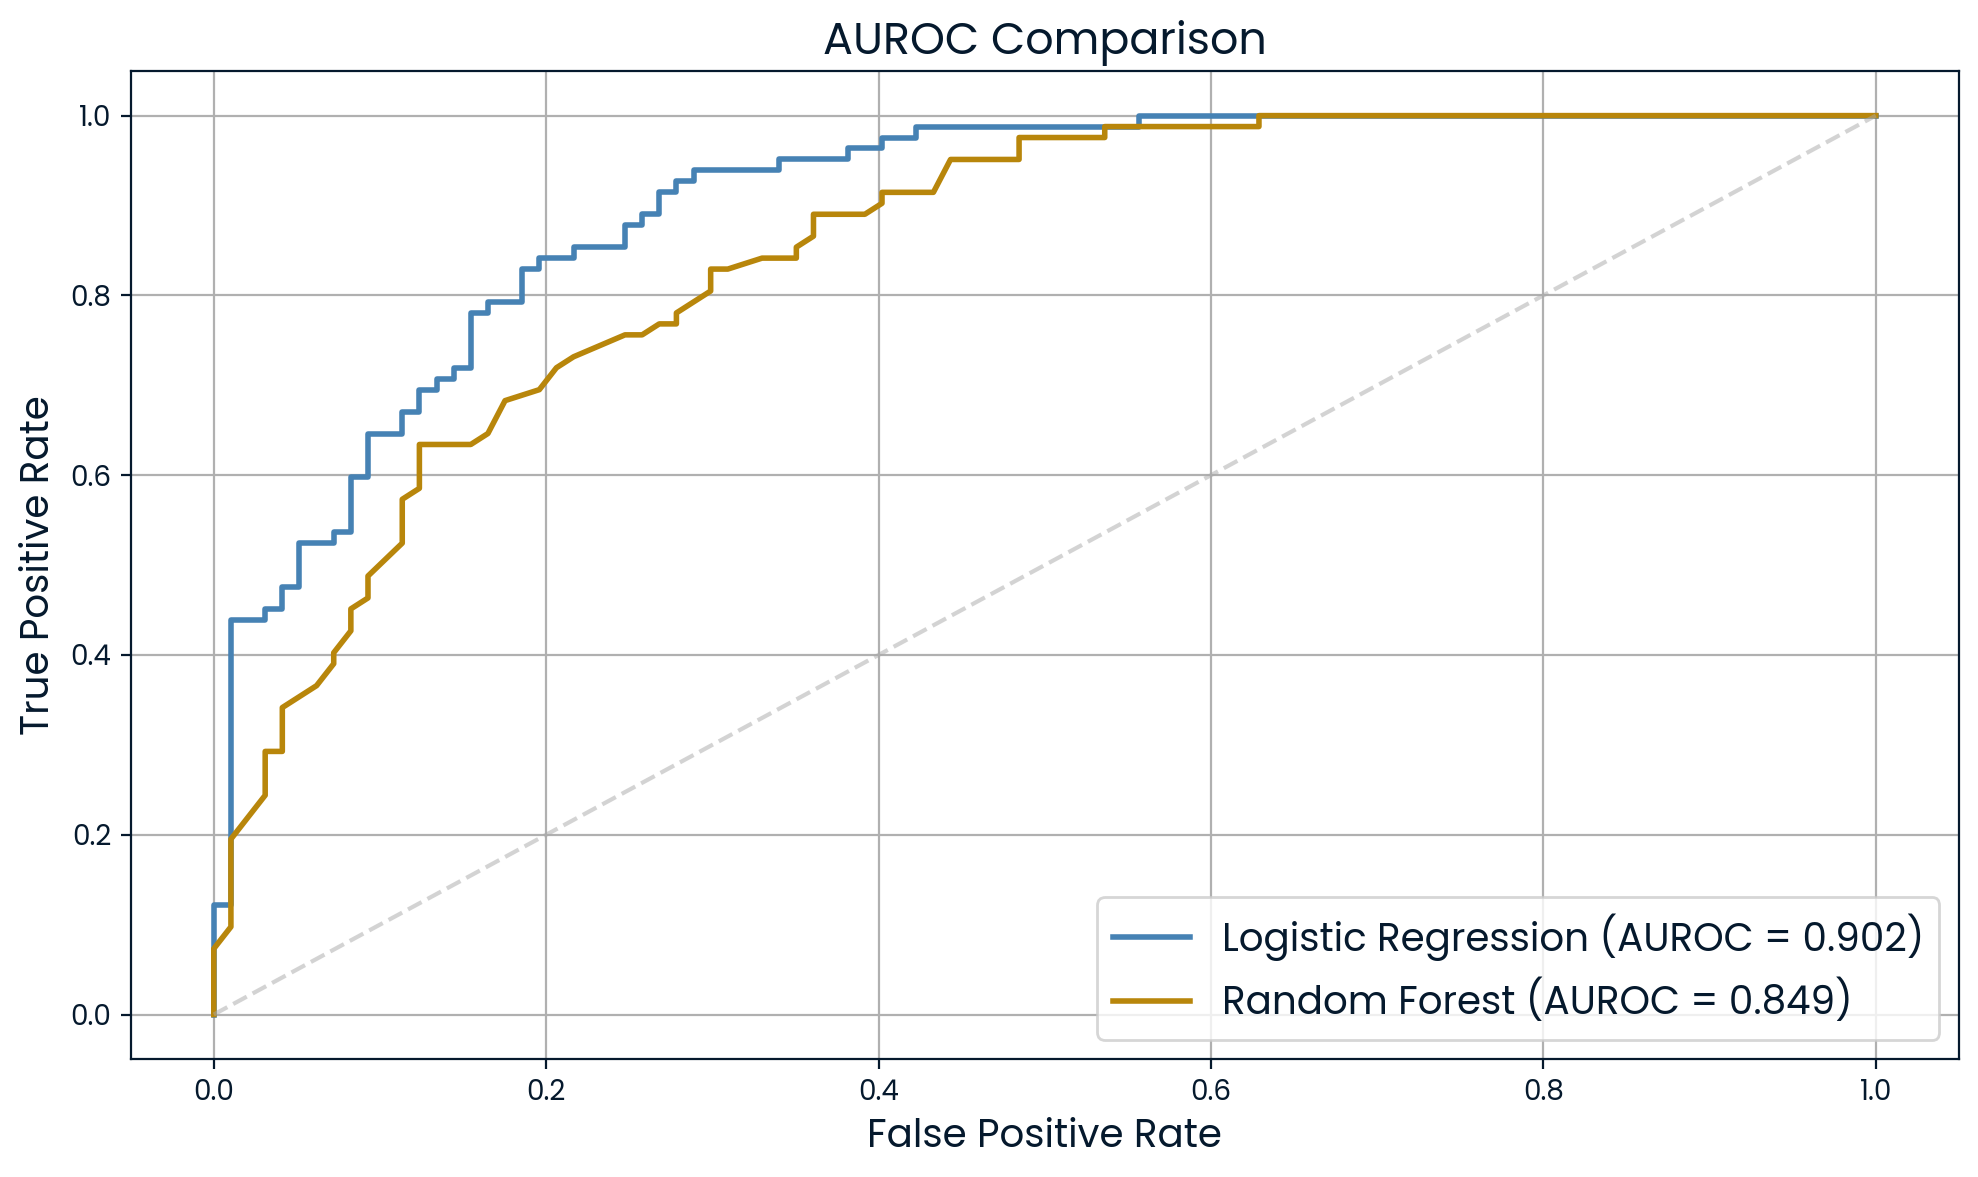

In [34]:
plot_models(lr_fpr, lr_tpr, lr_auroc, rf_fpr, rf_tpr, rf_auroc,
            label = 'AUROC', legend_position = [0.75, 0.2])

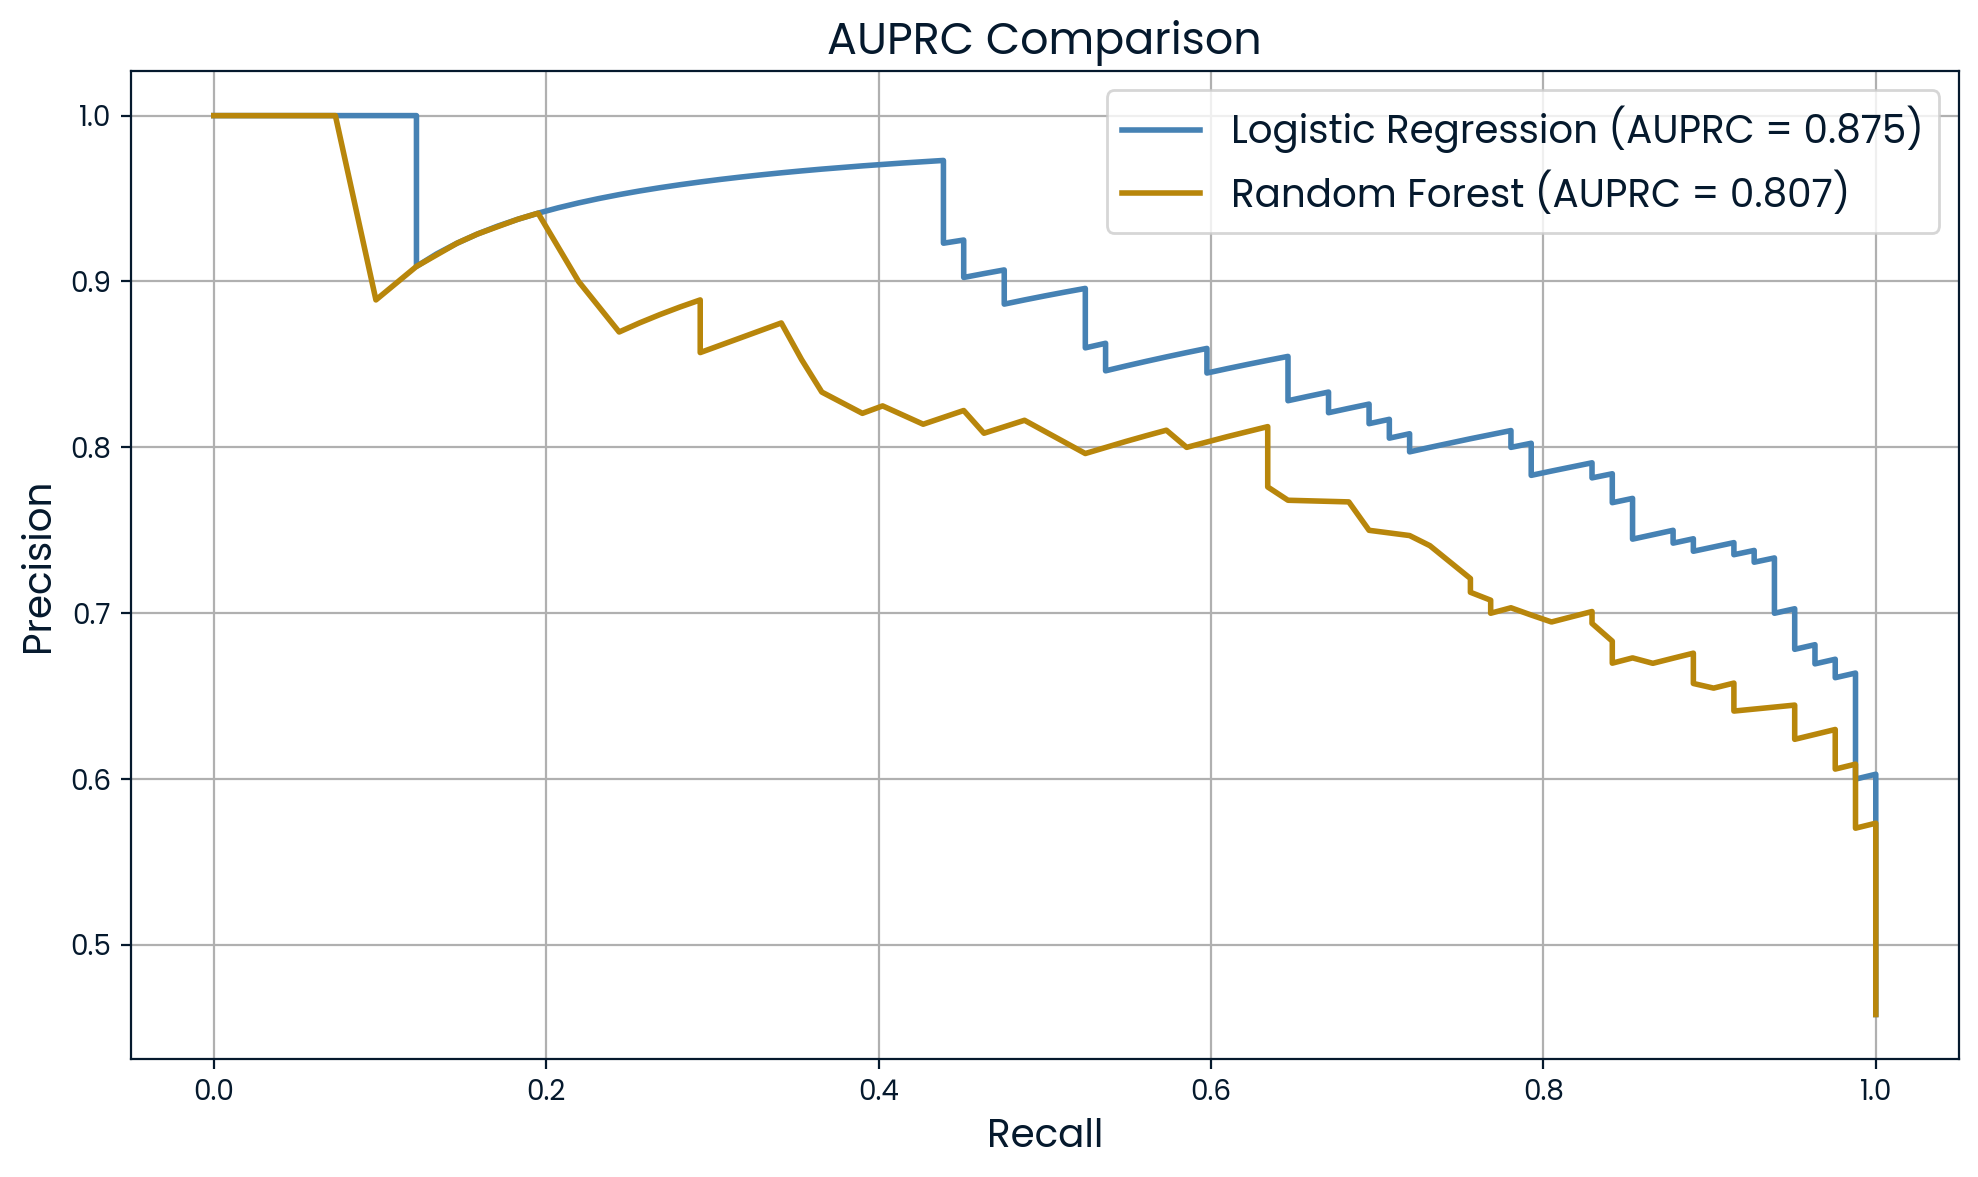

In [35]:
plot_models(lr_r, lr_p, lr_auprc, rf_r, rf_p, rf_auprc,
            label = 'AUPRC', legend_position = [0.3, 0.2])

Based on the performance of two models, Logistic Regression outperforms Random Forest in both metrics.
Logistic Regression's high AUPRC (Area Under the Precision-Recall Curve) score proof that it maintains high precision and recall across various threshold settings. It's high AUROC (Area Under the Receiver Operating Characteristic Curve) suggests that the model has a strong ability to distinguish between high traffic and low traffic recipes across all thresholds, with a 90.2% chance that it predicts correctly a high traffic recipe.
While Random Forest can also predict high traffic recipes 80% of the time, it is slightly less reliable than Logistic Regression.

## Business Metrics

To help align the predictive model's outcomes with business goal, we could use some of the KPI as business metrics:

- Conversion Rate: Measures the percentage of users who take a favorble action (e.g., clicking, reading, sharing or purchasing a recipe) on the total number of recipes displayed. This will be calculated by Precision - the ratio of True Positives (correctly predicted high traffic recipes) to the sum of True Positives and False Positives (recipes incorrectly predicted as high traffic).


In [36]:
def kpi(model, name):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_cm = confusion_matrix(y_train, train_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    f1_train = f1_score(y_train, train_pred)
    f1_test = f1_score(y_test, test_pred)
    TP = np.array([train_cm[0][0], test_cm[0][0]])
    FP = np.array([train_cm[0][1], test_cm[0][1]])
    FN = np.array([train_cm[1][0], test_cm[1][0]])
    TN = np.array([train_cm[1][1], test_cm[1][1]])
    F1 = np.array([f1_train, f1_test])
    recall = TP/(TP+FN)
    Cv_rate = TP/(TP+FP) * 100
    result = pd.DataFrame({"TP": TP, "FP": FP, "TN": TN, "FN": FN, "F1 Score": F1, "Recall": recall, "Conversion rate (%)": Cv_rate}, index=["Train", "Test"])
    print(f"High traffic Performance Indicator using {name}")
    print("---------------------------------------------------")
    print(result)

In [37]:
kpi(lr, "Logistic Regression")
print("===================================================")
kpi(rf, "Random Forest")

High traffic Performance Indicator using Logistic Regression
---------------------------------------------------
        TP  FP   TN  FN  F1 Score    Recall  Conversion rate (%)
Train  296  56  304  60  0.839779  0.831461            84.090909
Test    82  15   64  18  0.795031  0.820000            84.536082
High traffic Performance Indicator using Random Forest
---------------------------------------------------
        TP  FP   TN  FN  F1 Score    Recall  Conversion rate (%)
Train  352   0  364   0  1.000000  1.000000           100.000000
Test    73  24   62  20  0.738095  0.784946            75.257732


Based on the performance of these two models, we observe that the Random Forest model tends to overfit, performing very well (100%) on the training set but worse on the test set (75%). Logistic Regression maintains decent performance, achieving an 84% conversion rate on both train and test set.

From a business perspective, predicting high-traffic recipes as low-traffic is a more significant concern. Therefore, our emphasis is on model precision. We introduced a Key Performance Indicator (KPI) called the 'High Traffic Conversion Rate,' which should consistently exceed 84% based on our baseline model results.

Other Key Performance Indicator:
- High traffic Detection Rate: Recall measures how well the model identifies actual high traffic recipes (True Positives out of all actual high traffic recipes). Based on the performance of our base model, this should be at least 0.82

In addition to these KPIs, if we can track revenue data per recipe, we can also consider the following:

- Revenue per High Traffic Recipe: Tracks the average revenue generated from high-traffic recipes.
- Customer Retention Rate: Evaluates how well high-traffic recipes retain customers over time.
- Customer Lifetime Value (CLV): Estimates the total revenue a business can expect from a customer attributed to high-traffic recipes.

In conclusion, we find that Logistic Regression exceeds the 80% target in metrics like precision, recall to predict high traffic recipes. The Conversion Rate and High Traffic Detection Rate KPI serve as valuable metrics for our business model, providing insights into the accuracy of high traffic predictions.